<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit6/NeevSabhUnit6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb


#**Unit 6 Project: New York Housing Market**

For this project, I'll be creating a model that will predict the New York House Price using 3 key factors: BEDS, BATH, and PROPRETYSQFT, with SUBLOCALITY as a hierarchical factor. I chose the topic because real estate valuation is a complex yet fascinating field that blends economic ideas, market trends, and data-driven analysis. Given the variability of housing markets among sublocalities, I wanted to look into how these characteristics affect property values.

The predictors I selected—BEDS, BATH, and PROPRETYSQFT—are commonly used in real estate valuation to estimate property values. The number of bedrooms (BEDS) and bathrooms (BATH) provide insights into the functionality and size of a home, while the square footage (PROPRETYSQFT) is a direct measure of the home's overall space. Additionally, incorporating SUBLOCALITY as a hierarchical factor allows the model to capture regional variations in pricing trends across different areas, such as Queens, Manhattan, Brooklyn, and New York.

Hierarchical modeling using sublocalities accounts for the inherent variability between neighborhoods, increasing prediction precision by taking into account localized effects. This method is consistent with how real estate experts evaluate properties based on both individual characteristics and broader market conditions within certain areas.


On my casual diagram, I had included age of house, neighboorhood, interest rate, Broker, Type of house, State, city, locality, as well as the factors I'm including in my models. Why did I not choose to include interest rate, broker, type of hosue, etc.? We'll, the reason i choose to not include state, city, and locality is because im specifically looking at houses in New York City, so those variables are already controlled so there is no point in having them included in my model. The reason I didnt include interest rate, age of hosue, and neighborhood is because I did not have any data on these factors (to make up for neighborhood, im using sublocalities). The reason I did not include broker and type of house is because the type of house and broker don't have as strong of a effect on price as something like Square footage of a house. For example, a house labeled as a condo could cost less than a house labeled as Co-op, but the condo could be way tinier than the co-op. I also had extra variables in my dataset which I did not include. This was because it was information such as latitude, longitude, and address which dont contribute much because im already looking at sublocalities in New York.

##**DATA**

Due to the large sample size and dozens of different sublocalities, I filtered my data to only have 4 main sublocalities: Queens, Manhattan, Brooklyn, and New York. I also cut down to nly have 300 data points to make my model run better and faster.

In [ ]:
file_path = 'https://raw.githubusercontent.com/NeevSabhani/Data-Science/refs/heads/main/Unit6/NY-House-Dataset.csv'
NY_house = pd.read_csv(file_path)

# Define the sublocalities to keep
desired_sublocalities = ["Queens", "Manhattan", "Brooklyn", "New York"]

# Filter data to include only the desired sublocalities
filtered_data = NY_house[NY_house['SUBLOCALITY'].isin(desired_sublocalities)]

# Select the first 300 rows after filtering
NY_house1 = filtered_data.head(300)
NY_house1.reset_index(drop=True, inplace=True)
NY_house1


,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.0,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Douglas Elliman - 575 Madison Ave,Condo for sale,899500,2,2.0,2184.207862,157 W 126th St Unit 1B,"New York, NY 10027","157 W 126th St Unit 1BNew York, NY 10027",New York,New York County,New York,Manhattan,157,"157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777
2,Brokered by CENTURY 21 MK Realty,Co-op for sale,440000,2,1.0,978.000000,1350 Ocean Pkwy Apt 5G,"Brooklyn, NY 11230","1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
3,Brokered by COMPASS,Co-op for sale,259000,3,1.0,2184.207862,34-41 85th St Unit 1D,"Jackson Heights, NY 11372","34-41 85th St Unit 1DJackson Heights, NY 11372",New York,Queens County,Queens,Flushing,34-41,"34-41 85th St #1b, Flushing, NY 11372, USA",40.753119,-73.881876
4,Brokered by Jamie & Connie Real Estate Grp,Co-op for sale,430000,2,2.0,2184.207862,91-15 Lamont Ave Unit 6D,"Elmhurst, NY 11373","91-15 Lamont Ave Unit 6DElmhurst, NY 11373",New York,Queens County,Queens,Elmhurst,91-15,"91-15 Lamont Ave #6d, Elmhurst, NY 11373, USA",40.743864,-73.874572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Brokered by Douglas Elliman - 3544 Johnson Ave,House for sale,879000,2,1.0,1000.000000,1175 York Ave Apt 7B,"New York, NY 10065","1175 York Ave Apt 7BNew York, NY 10065",New York,New York County,New York,Manhattan,1175,"1175 York Ave #7b, New York, NY 10065, USA",40.761537,-73.957979
296,Brokered by Corcoran Chelsea/Flatiron,Co-op for sale,999995,2,1.0,2184.207862,126 E 12th St Apt 6A,"New York, NY 10003","126 E 12th St Apt 6ANew York, NY 10003",New York,New York County,New York,Manhattan,126,"126 E 12th St #6a, New York, NY 10003, USA",40.732200,-73.988900
297,NoBroker,Co-op for sale,445000,3,2.0,2184.207862,138-10 Franklin Ave Unit 1K,"Flushing, NY 11355","138-10 Franklin Ave Unit 1KFlushing, NY 11355",New York,Queens County,Queens,Flushing,138-10,"138-10 Franklin Ave #1g, Flushing, NY 11355, USA",40.754725,-73.825557
298,Brokered by COMPASS,Condo for sale,600000,3,1.0,441.000000,1 Central Park W Unit 612,"Manhattan, NY 10023","1 Central Park W Unit 612Manhattan, NY 10023",New York,New York County,New York,Manhattan,1,"1 Central Park W #612, New York, NY 10023, USA",40.769109,-73.981620


##**THE MODELS**

I will be using 6 differnent models:


1.   No interactions between BEDS, BATH, and PROPERTYSQFT
2.   Interaction between BATH + PROPERTYSQFT
3. Interaction between BEDS + BATH
4. Interaction between PROPERTYSQFT + BEDS
5. Two interactions between PROPERTYSQFT + BEDS and PROPERTYSQFT + BATH
6. Interaction between all three factors



###**1**

In [ ]:
# Define and fit the categorical model
model_1 = bmb.Model(
    "`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT`|SUBLOCALITY)",
    data=NY_house1
)
idata_1 = model_1.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


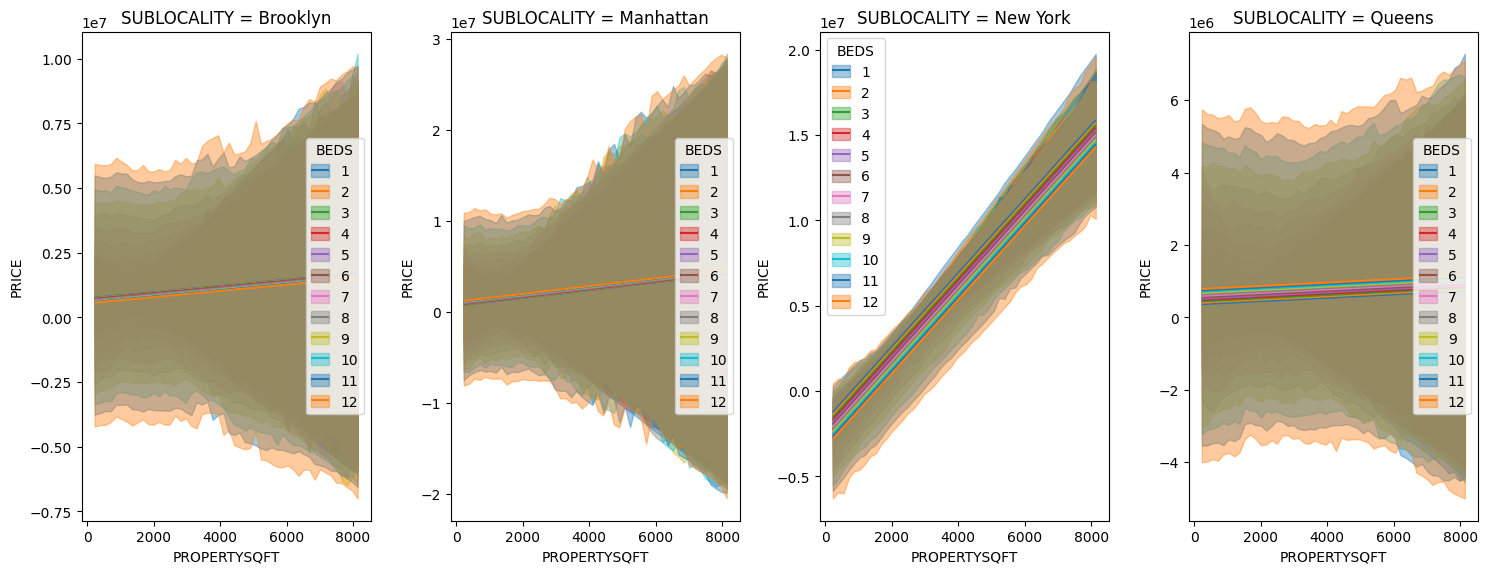

In [ ]:
bmb.interpret.plot_predictions(
    model_1,
    idata_1,
    ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

###**2**

In [ ]:
model_2 = bmb.Model("`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT` + `BATH`:`PROPERTYSQFT`|SUBLOCALITY)", data=NY_house1)
idata_2 = model_2.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1500x600 with 4 Axes>,
 array([<Axes: title={'center': 'SUBLOCALITY = Brooklyn'}, xlabel='PROPERTYSQFT', ylabel='PRICE'>,
        <Axes: title={'center': 'SUBLOCALITY = Manhattan'}, xlabel='PROPERTYSQFT', ylabel='PRICE'>,
        <Axes: title={'center': 'SUBLOCALITY = New York'}, xlabel='PROPERTYSQFT', ylabel='PRICE'>,
        <Axes: title={'center': 'SUBLOCALITY = Queens'}, xlabel='PROPERTYSQFT', ylabel='PRICE'>],
       dtype=object))

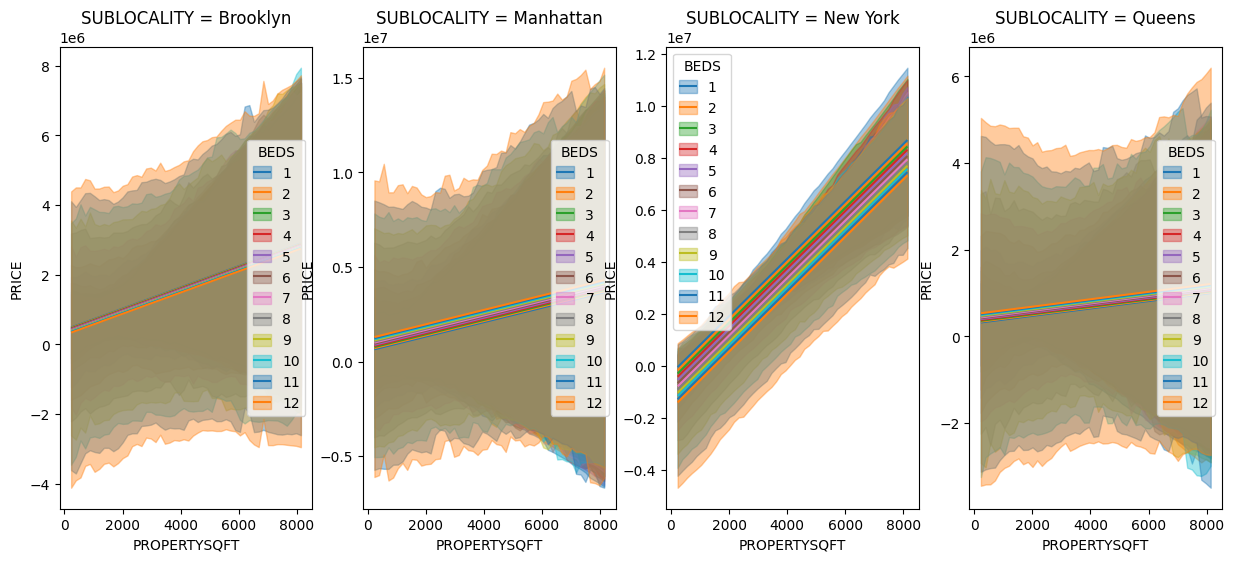

In [ ]:
bmb.interpret.plot_predictions(model_2,
                               idata_2,
                                ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"], fig_kwargs={"figsize":(15, 6)})

###**3**

In [ ]:
# Define and fit the categorical model
model_3 = bmb.Model(
    "`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT` + `BEDS`:`BATH`|SUBLOCALITY)",
    data=NY_house1
)
idata_3 = model_3.fit(idata_kwargs={'log_likelihood': True})


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


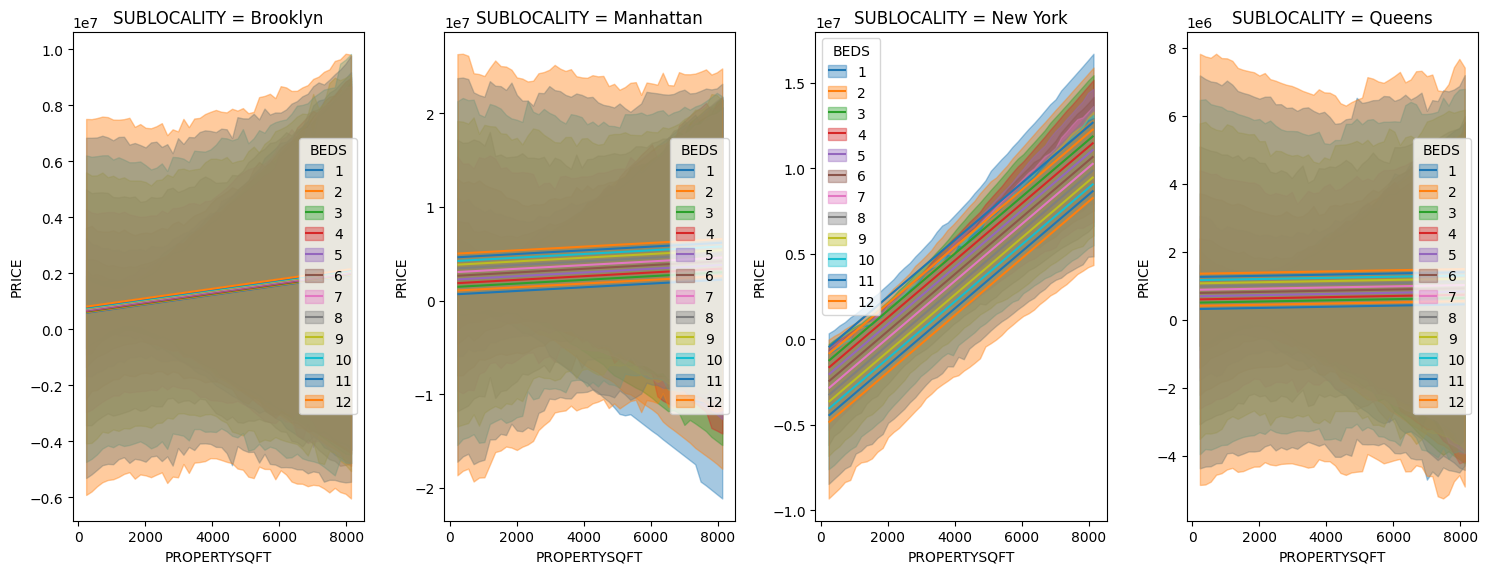

In [ ]:
# Visualize predictions
bmb.interpret.plot_predictions(
    model_3,
    idata_3,
    ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

###**4**

In [ ]:
# Define and fit the categorical model
model_4 = bmb.Model(
    "`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT` + `PROPERTYSQFT`:`BEDS`|SUBLOCALITY)",
    data=NY_house1
)
idata_4 = model_4.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


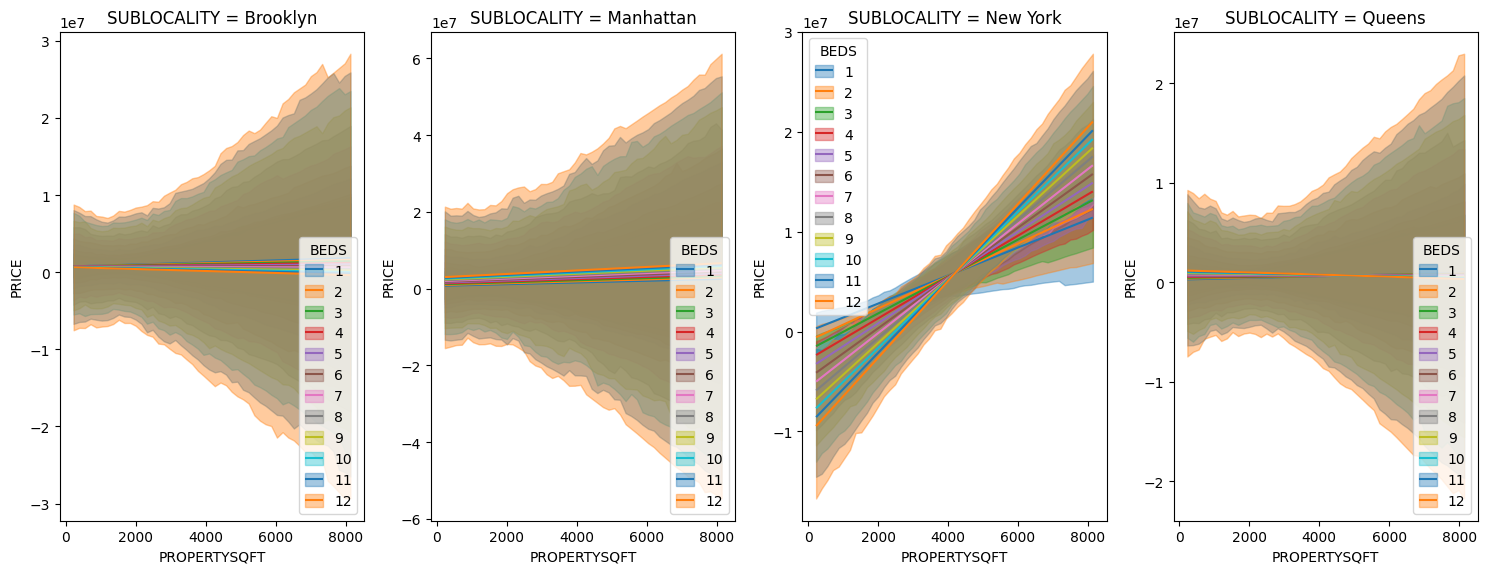

In [ ]:
bmb.interpret.plot_predictions(
    model_4,
    idata_4,
    ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

###**5**

In [ ]:
# Define and fit the categorical model
model_5 = bmb.Model(
    "`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT` + `PROPERTYSQFT`:`BEDS` + `PROPERTYSQFT`:`BATH`|SUBLOCALITY)",
    data=NY_house1
)
idata_5 = model_5.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


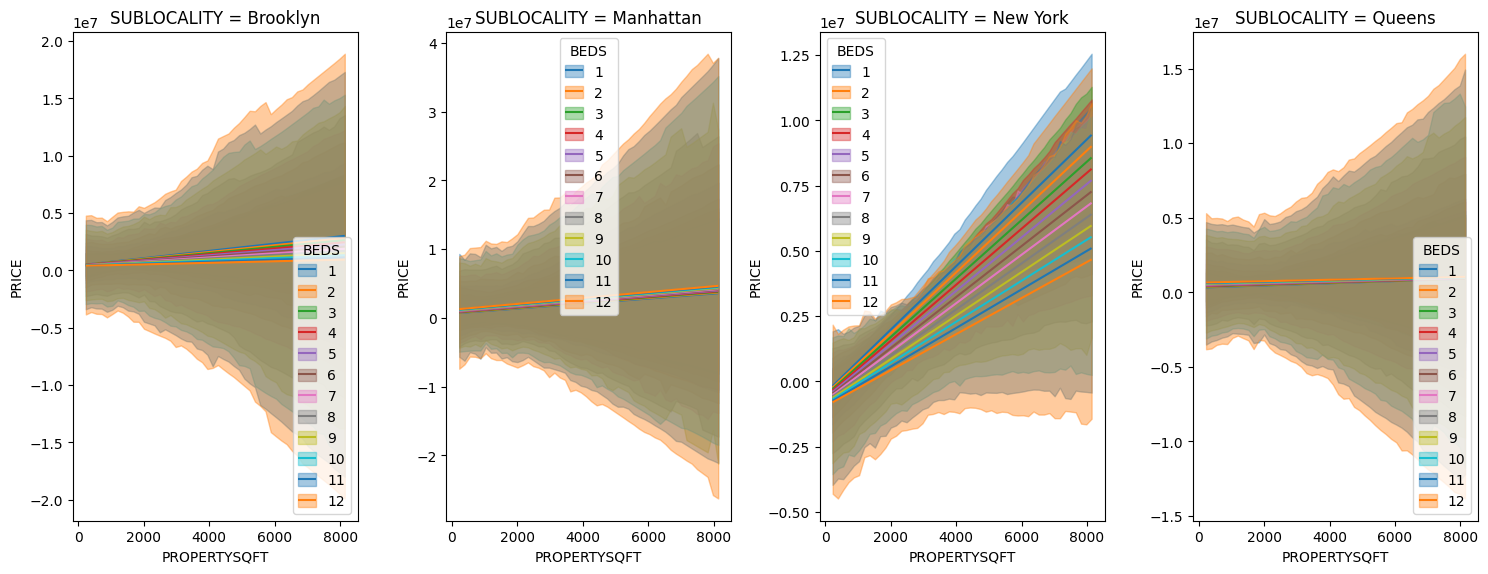

In [ ]:
bmb.interpret.plot_predictions(
    model_5,
    idata_5,
    ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

###**6**

In [ ]:
# Define and fit the categorical model
model_6 = bmb.Model(
    "`PRICE` ~ (`BEDS` + `BATH` + `PROPERTYSQFT` + `PROPERTYSQFT`:`BEDS` + `PROPERTYSQFT`:`BATH` + `BEDS`:`BATH`|SUBLOCALITY)",
    data=NY_house1
)
idata_6 = model_6.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


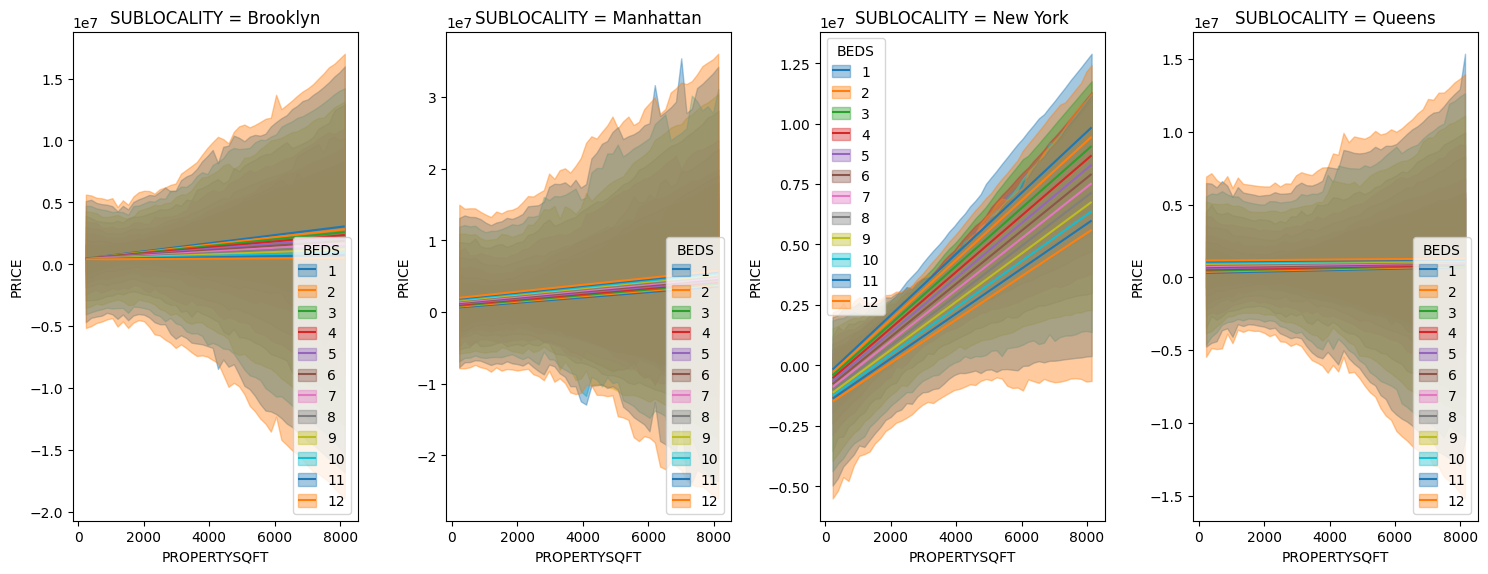

In [ ]:
bmb.interpret.plot_predictions(
    model_6,
    idata_6,
    ["PROPERTYSQFT", "BEDS",  "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

###**EXTRA**

For fun, I decided to use no hierarchy with interactions between SUBLOCALITY, BEDS, and PROPERTYSQFT.

Reason I choose beds and not baths is because in our casual diagram, we can see that the amount of baths relates to the amount of bedrooms  (in most cases).

In [ ]:
# Define and fit the categorical model
model_7 = bmb.Model(
    "`PRICE` ~ (`SUBLOCALITY` + `BEDS` + `PROPERTYSQFT` + `PROPERTYSQFT`:`BEDS` + `PROPERTYSQFT`:`SUBLOCALITY` + `SUBLOCALITY`:`BEDS`)",
    data=NY_house1
)
idata_7 = model_7.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


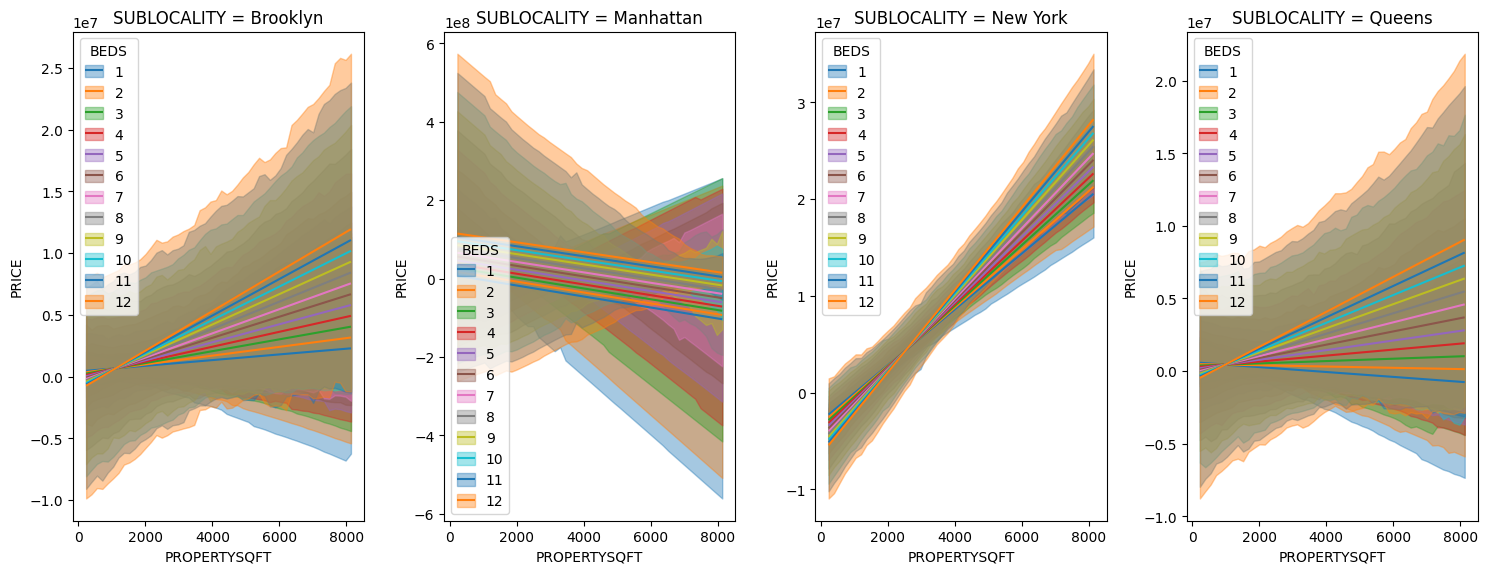

In [ ]:
bmb.interpret.plot_predictions(
    model_7,
    idata_7,
    ["PROPERTYSQFT", "BEDS", "SUBLOCALITY"],
    fig_kwargs={"figsize": (15, 6)},  # Increase figure size
)
plt.tight_layout()  # Optimize spacing of subplots
plt.show()

##**RESULTS**

1.   No interactions between BEDS, BATH, and PROPERTYSQFT
2.   Interaction between BATH + PROPERTYSQFT
3. Interaction between BEDS + BATH
4. Interaction between PROPERTYSQFT + BEDS
5. Two interactions between PROPERTYSQFT + BEDS and PROPERTYSQFT + BATH
6. Interaction between all three factors
7. Extra

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

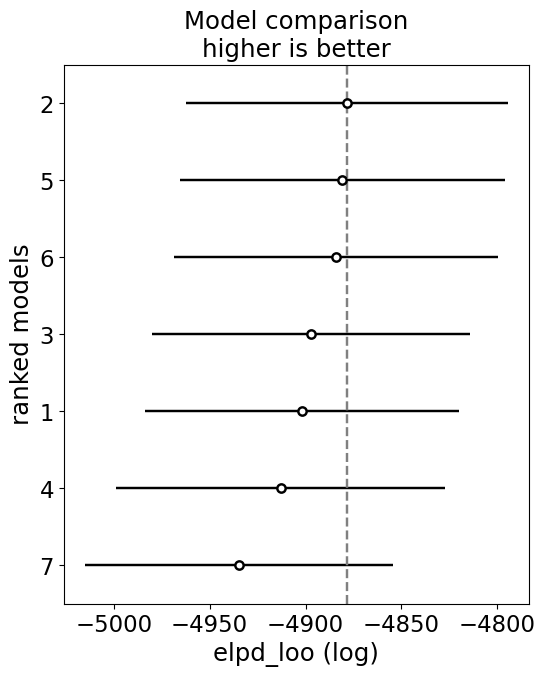

In [ ]:
bd = az.compare({"2":idata_1,"3":idata_2, "1":idata_3, "4":idata_4, "5":idata_5, "6":idata_6, "7":idata_7})
az.plot_compare(bd)

Since all of our elpd_loo values are very similar, it doesn't clearly tell us which model is the best, so let's look at the ppc for each model.

1.   No interactions between BEDS, BATH, and PROPERTYSQFT
2.   Interaction between BATH + PROPERTYSQFT
3. Interaction between BEDS + BATH
4. Interaction between PROPERTYSQFT + BEDS
5. Two interactions between PROPERTYSQFT + BEDS and PROPERTYSQFT + BATH
6. Interaction between all three factors

###**Model 2: Interaction between BATH + PROPERTYSQFT**

<Axes: xlabel='PRICE'>

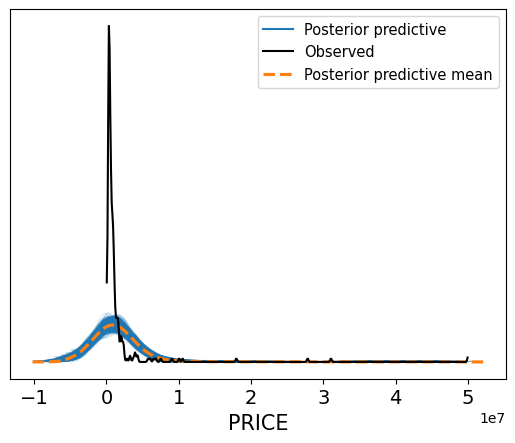

In [ ]:
model_2.predict(idata_2, kind="response")
az.plot_ppc(idata_2)

###**Model 5: Two interactions between PROPERTYSQFT + BEDS and PROPERTYSQFT + BATH**

<Axes: xlabel='PRICE'>

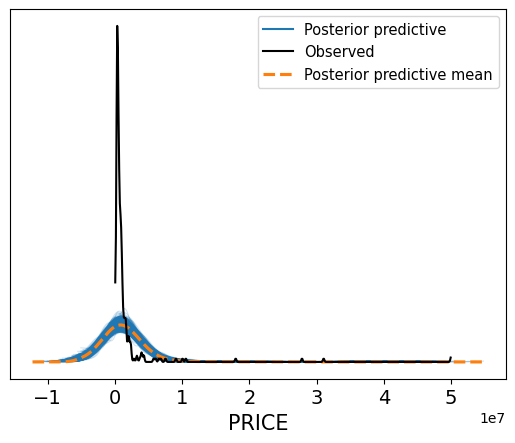

In [ ]:
model_5.predict(idata_5, kind="response")
az.plot_ppc(idata_5)

###**Model 1: No interaction**



<Axes: xlabel='PRICE'>

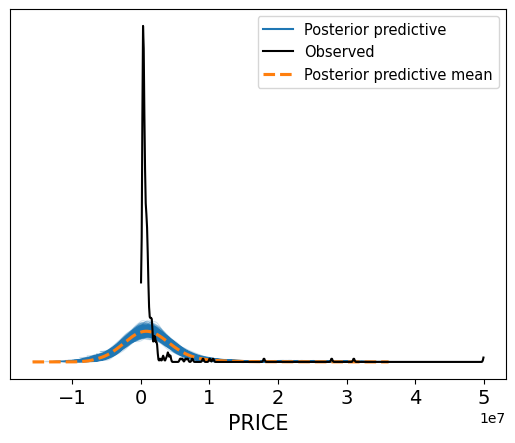

In [ ]:
model_1.predict(idata_1, kind="response")
az.plot_ppc(idata_1)

###**Model 3:Interaction between BEDS + BATH**

<Axes: xlabel='PRICE'>

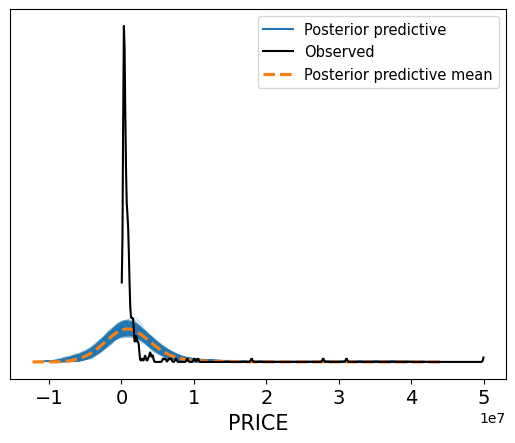

In [ ]:
model_3.predict(idata_3, kind="response")
az.plot_ppc(idata_3)

###**Model 4: Interaction between PROPERTYSQFT + BEDS**

<Axes: xlabel='PRICE'>

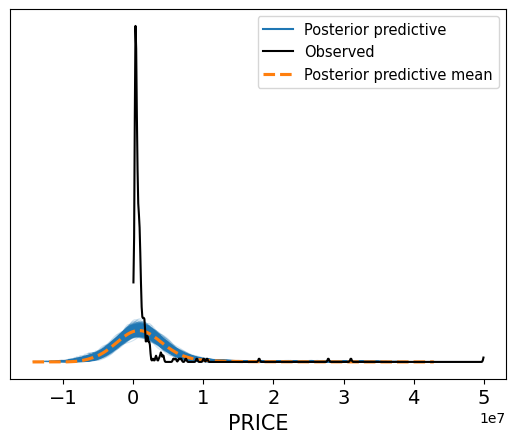

In [ ]:
model_4.predict(idata_4, kind="response")
az.plot_ppc(idata_4)

###**Model 6: Interaction between all 3**

<Axes: xlabel='PRICE'>

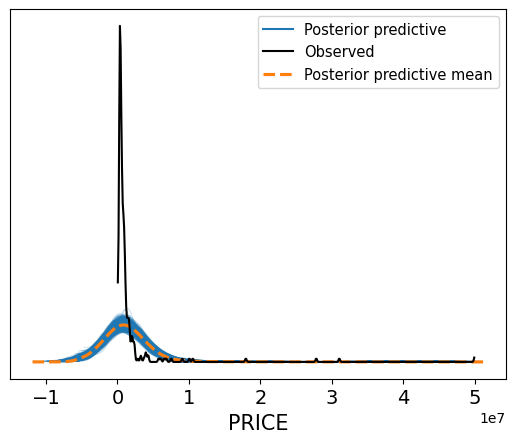

In [ ]:
model_6.predict(idata_6, kind="response")
az.plot_ppc(idata_6)

###**Model 7: Our extra model**

<Axes: xlabel='PRICE'>

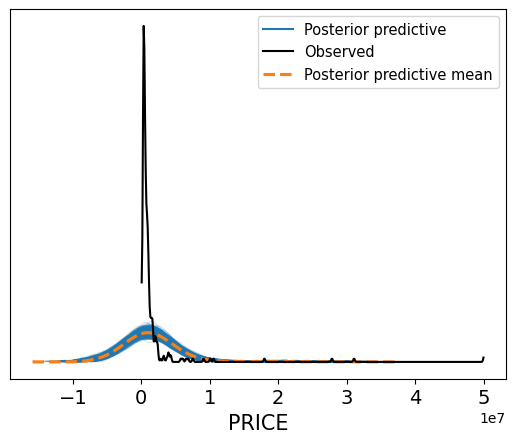

In [ ]:
model_7.predict(idata_7, kind="response")
az.plot_ppc(idata_7)

###**What do we see?**

Looking at the ppc for each one, we can see that they all performed similar, but models 2 and 5 had the, by very slightly, higher peak compared to the rest.

 Model 2, which includes an interaction between BATH and PROPERTYSQFT, performing well makes sense—larger homes often have more bathrooms, and their combined effect on price could be more significant than when considered separately. This suggests that the relationship between property size and the number of bathrooms plays a  role in determining house prices.

Model 5, which includes interactions between PROPERTYSQFT with both BEDS and BATH, also performed well. This result indicates that property size may moderate the effect of both bedrooms and bathrooms on price, potentially capturing nuances such as the optimal distribution of space within a home. Larger properties might be valued differently based on how bedrooms and bathrooms are distributed, which could explain why incorporating these interactions improves predictive accuracy.

On the other hand, Model 1, which does not include any interactions, did not perform as well. This suggests that considering interactions between these factors is important for improving model performance.

It’s interesting to note that Model 4, which includes an interaction between PROPERTYSQFT and BEDS, performed as bad as Model 1, which assumes no interactions between the predictors. This suggests that the relationship between square footage and the number of bedrooms may not be as straightforward or significant in determining house prices as one might expect.

One possible reason for this could be that the number of bedrooms alone does not add much power when interacting with square footage. Larger homes may have varying layouts that do not always correlate directly with the number of bedrooms, meaning other factors—such as overall design, amenities, or neighborhood—could play a more important role in pricing than just the interaction between size and bedrooms.

Additionally, it could indicate that buyers prioritize other aspects of a home other than the number of bedrooms in relation to square footage. For example, homes with fewer but larger bedrooms might be more desirable than homes with a higher bedroom count in a similar-sized property. This lack of a strong relationship could explain why including the interaction actually led to worse model performance compared to a simpler model.



